# 0. create project structure and import utility functions
After doing this, put the required files in the "Input_files" folder. Including approximate names, these should be:
- Slide-tags spatial data   :   "df_whitelist_{Sample/Project/Run}.csv"
- 10x barcode pairs         :   "3M-february-2018.txt"                      or equivalent
- Known cell barcodes       :   "barcodes_{Sample}.csv"                     Single-cell derived barcodes
- Slide-tags results        :   "{Sample}_spatial.csv"                      Slide-tags results, used to analyse check results but not strictly required until then

It is also possible in each step to re-load config if changes are done in the middle.

In [1]:
from Utils import *
create_structure()
config = ConfigLoader('config_standard_processes.py') 

# 1. Process raw edge file

The edge file (df_whitelist_{Project}.txt) generated from Russell et als' pipeline will go through slight modification for easier handling in the downstream.

- The first cell loads packages and creates project structure if not already present, after running this the required files should be added to the "Input_files" folder. 

- The second step is mandatory, and entails switching the cell barcodes with their counterpart in the 10X provided barcode document denoted "3M-february-2018.txt".

- The third step is optional, and entails filtering the edge list, keeping only cells with a known position, as determined by Russell et al. This can also be used to remove any other barcodes you do not want to analyze. Both of these files are downloaded from the NCBI single-cell database for each specific experiment.

In [2]:
from initial_processing_functions import perform_preprocessing
perform_preprocessing(config)


Filtered whitelist reindexed
               cell_bc_10x         bead_bc  nUMI
0        AAACCCATCATCGCAA  AAAAATGTCCAGCC     1
1        AAACCCATCATCGCAA  AAACTAACACGTAC     1
2        AAACCCATCATCGCAA  AACCCGAAACGATT     1
3        AAACCCATCATCGCAA  AACCCGCGGGAGCT     1
4        AAACCCATCATCGCAA  AACCTGAACCCATA     1
...                   ...             ...   ...
1949179  TTTGTTGAGTAGGAAG  TTTCGTCCGCCGAT     1
1949180  TTTGTTGAGTAGGAAG  TTTGGGTGTGCGTG     1
1949181  TTTGTTGAGTAGGAAG  TTTGGTAATCTCGT     1
1949182  TTTGTTGAGTAGGAAG  TTTGTATGCATCGC     5
1949183  TTTGTTGAGTAGGAAG  TTTGTTGGACAAGT     1

[1949184 rows x 3 columns]


# 2. Filter edgelist
The main purpose is to remove certain beads with undesirable properties. 
By default, the options are that of the tonsil analysis in the manuscript:
- Lower limit of 2 UMI's per bead
- Upper limit of 1500 UMIs per bead
- Removal of any bead with an "N" in the bead sequence 

There are also other options for filtering that are not active by default:
- Filtering beads based on degree
- Imposing a lower limit of number of UMIs per edge

In [3]:
from filtering_functions import perform_filtering

perform_filtering(config)

                     cell_bc_10x  nUMI
bead_bc                               
AAAAATGTCCAGCC  AAACCCATCATCGCAA     1
AAACTAACACGTAC  AAACCCATCATCGCAA     1
AACCCGAAACGATT  AAACCCATCATCGCAA     1
AACCCGCGGGAGCT  AAACCCATCATCGCAA     1
AACCTGAACCCATA  AAACCCATCATCGCAA     1
...                          ...   ...
TTTATCGACAATCC  TTTGTTGAGTAGGAAG     1
TTTCCGCATGGAGG  TTTGTTGAGTAGGAAG     2
TTTGGGTGTGCGTG  TTTGTTGAGTAGGAAG     1
TTTGGTAATCTCGT  TTTGTTGAGTAGGAAG     1
TTTGTATGCATCGC  TTTGTTGAGTAGGAAG     5

[1620741 rows x 2 columns]
                bead_bc       cell_bc_10x  nUMI
0        AAAAATGTCCAGCC  AAACCCATCATCGCAA     1
1        AAACTAACACGTAC  AAACCCATCATCGCAA     1
2        AACCCGAAACGATT  AAACCCATCATCGCAA     1
3        AACCCGCGGGAGCT  AAACCCATCATCGCAA     1
4        AACCTGAACCCATA  AAACCCATCATCGCAA     1
...                 ...               ...   ...
1620736  TTTATCGACAATCC  TTTGTTGAGTAGGAAG     1
1620737  TTTCCGCATGGAGG  TTTGTTGAGTAGGAAG     2
1620738  TTTGGGTGTGCGTG  TTTGTTGA

# 3. Generate subgraphs
A subgraph is a component of a network in case that netqwork is not fully connected and is how all networks are referred to in the pipeline. This function allows us to impose multiple lower bound filterings to analyze how and if subgraphs are formed at each filtering threshold.
By default, the options are that of the tonsil analysis in the manuscript:
- The bead-cell bipartite network is used
- Only subgraphs with 50 or nodes (cells and/or beads) are kept
- No other filtering is applied

Other subgraph generation options include:
- Switching network type - bipartite bead-cell (default) AND/OR unipartite cell-cell
- Changing subgraph lower size limit (50 default)
- Unipartite filtering type - Unipartite cell-cell networks can be filtered either based on bead-per-edge or UMIs-per-edge
- Changing filtering thresholds - Multiple lower threshoplds can be specified and all will be used and generate subgraphs (default None)


In [4]:
from subgraph_processing_functions import perform_subgraph_generation_by_filtering
perform_subgraph_generation_by_filtering(config)

No Unipartite bead-weight matrix found
No Unipartite UMI-weight matrix found


# 4. Reconstruct
After generating the desired subgraphs, for which there are serveral options;
- Number of reconstructions - performing multiple recosntructions to i.e. assess variance in quality metrics (default: 1)

There multiple tiered options for choosing exactly which subgraphs to reconstruct:
1. Choosing which dimension to recosntruct into - the reconstruction algorithm can produce any dimension of int hef inal coordianates, although only 2 and 3 dimension is supported in this pipeline (default: 2D)
2. Choosing to reconstruct all or not - if True, all subgraphs from all thresholds are reconstructed (default: False)
3. Choosing the network type to reconstruct - bi- (bead-cell) or unipartite (cell-cell), if unipartite also the filtering type (beads, umi, or both) wehile bipartiote only has the "umi" filtering type (default: bipartite, umi)
4. Choosing to reconstruct all filtering threshold or a selection of specific ones (default: all)
5. Choosing which specific subgraphs to reconstruct - options include all subgraphs, the biggest subgraph, or choosing a specific one based on its number (default: all)

One additional option is whether to delete the files in the STRND structure after reconstruction completion. This is by default True, since all files are copied to other locations it is recommended to keep True

Summarized, the default is that all subgraphs (of which there should generally only be a single subgraph) of the bipartite bead-cell network is reconstructed in 2D once without additional filtering. If the default was used for the prior steps as well, the reconstruction should take around 10 minutes to complete, depending on exact computing specifications.

In [5]:
from reconstruction_functions import interpret_config_and_reconstruct
interpret_config_and_reconstruct(config)

['bi-umis_1']
['bi-umis_1']
['bi-umis_1']
['bi-umis_1']
input         Subgraph_edgelists/tonsil/run=all_cells_filters=numi2-1500_nconn2-1500_w1/bi-umis_1/subgraph_1_N=93859_unw.csv
info output   STRND_structure/tonsil/run=all_cells_filters=numi2-1500_nconn2-1500_w1/bi-umis_1
strnd input   STRND_structure/data/edge_lists
strnd recon   STRND_structure/data/reconstructed_positions
final output  Subgraph_reconstructions/tonsil/run=all_cells_filters=numi2-1500_nconn2-1500_w1/bi-umis_1_2D
Project structure created under 'c:\Users\simon.kolmodin\Desktop\Slide_Tag\github_publication_test/STRND_structure'
Title Edge List subgraph_1_N=93859_unw.csv
proximity_mode experimental
Unweighted graph
No duplicates found.
Edge list columns are valid.
Disconnected (or disordered) graph! Finding largest component...
Size of the total graph 389100
Size of largest connected component: 93859
Average Degree sparse: 34.41858532479571
running reconstruction...
reconstruction mode: STRND
ground truth available: F

  0%|          | 0/938590 [00:00<?, ?it/s]

reconstruction done!
                                                             Value  \
Property                                                             
num_points                                                   93859   
num_edges                                                  1615247   
average_degree                                           34.418585   
proximity_mode                                        experimental   
dimension                                                        2   
edge_list_title  edge_list_N=93859_dim=2_experimental_edge_list...   
bipartiteness                                                False   

                       Category  
Property                         
num_points       Graph Property  
num_edges        Graph Property  
average_degree   Graph Property  
proximity_mode        Parameter  
dimension             Parameter  
edge_list_title       Parameter  
bipartiteness    Graph Property  


# 5. Reconstruction analysis

Assessing the results of the reconstruction is the final step of a first-pass reconstruction, and of this notebook.
Note it uses a separate config file. Where as the config for the previous steps was used to choose processing steps, for the analysis the config is used to identify the subgraphs of interest.

This function does two main things:
1. Produces three files required in further analysis; a detailed edgelist, a summary of the reconstructed positions for all reconstructions, and a summary of the per-node quality metrics
2. Produce a plot showing the reconstruction side-by-side with the available reference positions which includes quality metrics CPD and KNN

The options for choosing subgraphs to analyse are similar to previous steps i.e. reconstruction dimension, network type, and various filtering parameters. Default is finding the subgraphs produced by the previous defaults.

In the context of this first-pass reconstruction notebook, notable options are:
- Choosing *K* for the KNN quality metric (Default: 15)
- Various visualization options include:
  - Plotting one or multiple reconstructions (if present)
  - Showing the reconstructed points or their distortion, and choosing between unmorphed or morphed versions (Default: Base reconstruction)
  - Cell coloring scheme (Default: by cell type, with colors provided by cell_colors.py)
  - Choosing colormap
  - image output format (Default: PNG)

There are also other options, but they are more relevant after further analysis performed in other notebooks.
After performing this step, there are several options on how to proceed:
1. Perform more in-depth analysis on the reconstruction with many options in the "additional_subgraph_analysis" notebook
2. Perform an iterative reconstruction in the "subgraph_modification" notebook
3. Perform the biological analysis using the R-based "slidetags-network" R project

Initializing files

Current Threshold:  1
Initializing files
Reading edgelist
Generating Subgraph object
Creating ground truth positions dataframe
check: Output_files\tonsil\run=all_cells_filters=numi2-1500_nconn2-1500_w1\bi-umis_1_2D/full_reconstruction_summary_subgraph_1_N=93859.csv
       node_ID           node_bc          node_type  type_prediction_score  \
0            1  AAACCCATCATCGCAA           B_memory                     -1   
1            2  AAACCCATCCGATCGG  B_germinal_center                     -1   
2            3  AAACCCATCGGTTAGT            B_naive                     -1   
3            4  AAACCCAGTCATTGCA            B_naive                     -1   
4            5  AAACCCACAGAAGTGC  B_germinal_center                     -1   
...        ...               ...                ...                    ...   
93854   387969    CATCGGCAATACTT               bead                     -1   
93855   387995    TTAAAGCCATGTCC               bead                     -1   
93856   3885

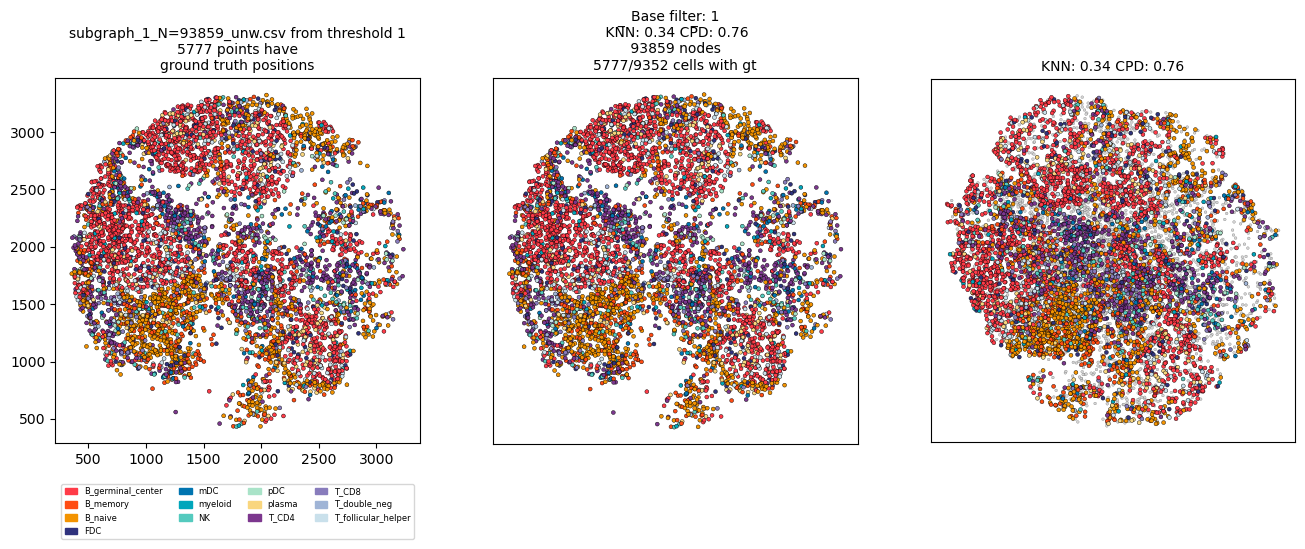

In [2]:
from subgraph_analysis_functions import perform_analysis_actions
config_analysis = ConfigLoader('config_subgraph_analysis.py') 

perform_analysis_actions(config_analysis)

This plot layout is such that to the left is the points in the subgraph with a ground truth overlayed on all ground truth points in light gray. To the right of this are the reconstructions, with the first row always being the ground truth positions for the that speicfic subgraph verions. The title of the column is the base filuter used, the mean KNN and CPD for all reconstrcutions fi there are multiple, how many total nodes in the subgraph including beads, and finally how many of those nodes are cells, and of those how many have a ground truth. The first column to the right of this will always be the base subgraph, without modifications. If there are multiple reconstructions shown (default is 1 reconstruction only) they wil be visible as rows under the ground truth, and if there are modified version of the subgraph, those will be new columns. the best reconstruction from a global perspective will have a blue outline, as well of the modification with the overall best global reconstruction quality